/tmp/ipykernel_80069/1448463310.py:17: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  test_images = torch.from_numpy(test_images).float()


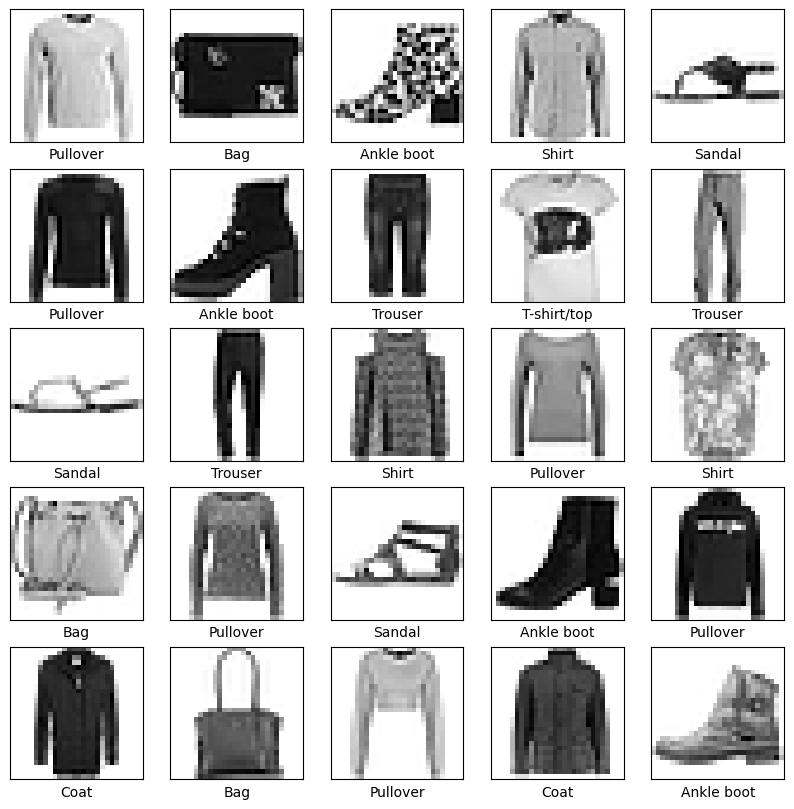

네트워크의 10000개 테스트 이미지 정확도: 87 %


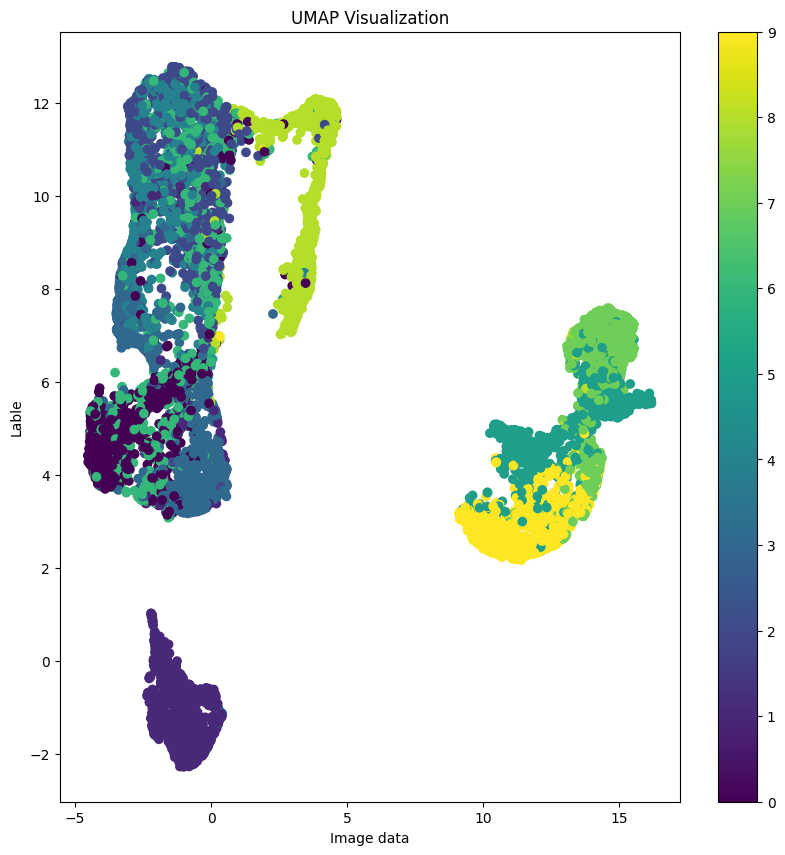

In [13]:
#202221876 김주환 중간고사 대체 과제 pytorch 버전
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import umap
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 데이터를 Tensor로 변환하고 정규화
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 테스트 이미지 데이터 로드
with gzip.open('./t10k-images-idx3-ubyte.gz', 'rb') as imgpath:
    test_images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(10000, 28, 28, 1)
test_images = torch.from_numpy(test_images).float()
test_images /= 255.0

# 테스트 레이블 데이터 로드
with gzip.open('./t10k-labels-idx1-ubyte.gz', 'rb') as lbpath:
    test_labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
test_labels = torch.from_numpy(test_labels)

# 클래스 이름 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 데이터 시각화
dataiter = iter(trainloader) #반복하는 iter 생성하여 배치 단위로 데이터 가여오기
images, labels = next(dataiter) #해당 이미지 데이터에 대한 실제 레이블 정보를 가져오기

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i].item()])
plt.show()

# UMAP
umap_reducer = umap.UMAP()
test_images_umap = np.array([])
test_labels = np.array([])
for images, labels in testloader:
    test_images_umap = np.concatenate((test_images_umap, images.numpy().reshape(images.size(0), -1)), axis=0) if test_images_umap.size else images.numpy().reshape(images.size(0), -1)
    test_labels = np.concatenate((test_labels, labels.numpy()), axis=0) if test_labels.size else labels.numpy()

embedding = umap_reducer.fit_transform(test_images_umap)

# 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 13 * 13, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss() #다중클래스 분류위한 손실 함수 https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 참조 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #확률적 경사법 SGD 사용 https://pytorch.org/docs/stable/optim.html 참조

# 모델 학습
for epoch in range(5):  # 데이터셋 반복 횟수 5회
    running_loss = 0.0 #손실 초기화
    for i, data in enumerate(trainloader, 0): 
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels) #손실함수 사용해 출려과 손실 비교 후 계산 https://nuguziii.github.io/dev/dev-002/ 참조
        loss.backward() #그레디언트 계산 https://velog.io/@jkl133/pytorch%EC%9D%98-autograd%EC%97%90-%EB%8C%80%ED%95%B4-%EC%95%8C%EC%95%84%EB%B3%B4%EC%9E%90 참조
        optimizer.step()
        running_loss += loss.item()

# 모델 평가
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('네트워크의 10000개 테스트 이미지 정확도: %d %%' % (100 * correct / total))

# UMAP 시각화
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=test_labels, cmap='viridis')
plt.colorbar()
plt.xlabel('Image data')
plt.ylabel('Lable')
plt.title('UMAP Visualization')
plt.show()

가장 잘못 매칭된 클래스는: Coat


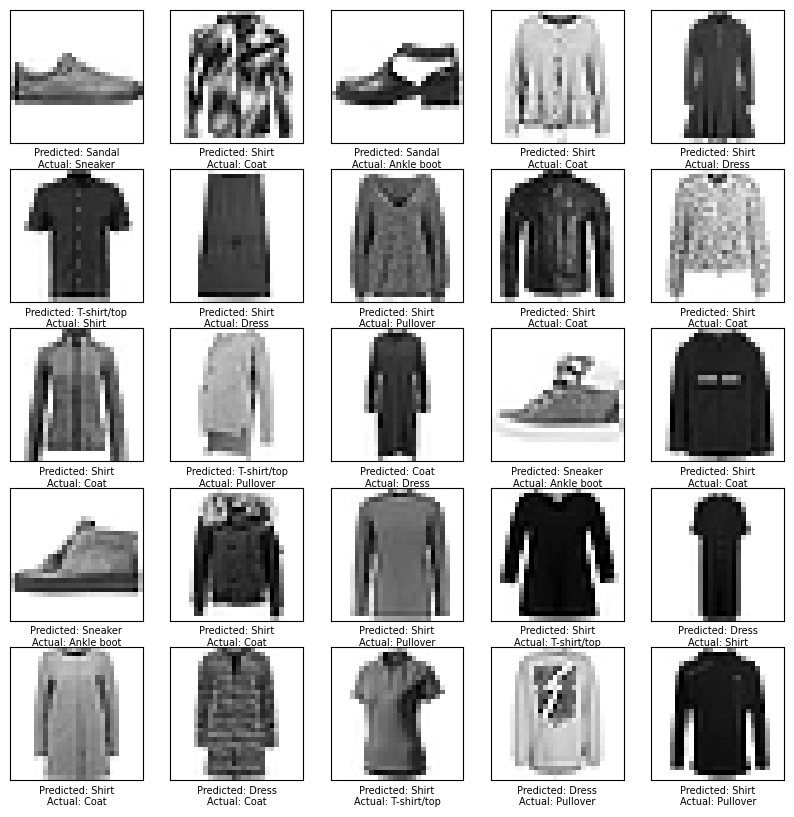

In [11]:
# 모델 예측 및 잘못 분류된 이미지 시각화
incorrect_images = []
incorrect_predictions = []
correct_labels = []
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                incorrect_images.append(images[i])
                incorrect_predictions.append(predicted[i])
                correct_labels.append(labels[i])
        if len(incorrect_images) >= 25:
            break

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(incorrect_images[i][0], cmap=plt.cm.binary)
    plt.xlabel(f'Predicted: {class_names[incorrect_predictions[i].item()]}\nActual: {class_names[correct_labels[i].item()]}', fontsize=7, wrap=True)

# 잘못 분류된 클래스 식별
misclassified_classes = [class_names[correct_labels[i].item()] for i in range(len(correct_labels))]
most_common_misclassified_class = max(set(misclassified_classes), key=misclassified_classes.count)
print(f"가장 잘못 매칭된 클래스는: {most_common_misclassified_class}")